In [1]:
FULL_TRAINING = False
import random
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pynvml import *
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    


In [2]:
if FULL_TRAINING:
    vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
    nlp_hf_model = "klue/roberta-base"
    
    # Reference: https://github.com/huggingface/transformers/issues/15823
    # initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
    # Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(vision_hf_model, nlp_hf_model)
    tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
else:
    trocr_model = 'daekeun-ml/ko-trocr-base-nsmc-news-chatbot'
    model = VisionEncoderDecoderModel.from_pretrained(trocr_model)
    tokenizer = AutoTokenizer.from_pretrained(trocr_model)     

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

-  데이터 구축

In [5]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':80,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정


In [8]:
df=pd.read_csv('train.csv')
df.drop(['id'],axis=1,inplace=True)
df.img_path=df.img_path.apply(lambda x: x.lstrip('./'))

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [9]:
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [10]:

df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.1, random_state=CFG['SEED'])

In [11]:
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

156157 14718


In [12]:
train_df=train.drop('len',axis=1)
test_df=val.drop('len',axis=1)

In [13]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

- 데이터 셋 생성 함수

In [14]:
class OCRDataset(Dataset):
    def __init__(self, dataset_dir, df, processor, tokenizer, max_target_length=32):
        self.dataset_dir = dataset_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['img_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.dataset_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text      
        labels = self.tokenizer(text, padding="max_length", 
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [21]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
dataset_dir = './'
max_length = 32

train_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=train_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)
eval_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=test_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Number of training examples: 156157
Number of validation examples: 14718


pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


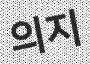

In [22]:
img_idx = np.random.randint(len(train_df))
encoding = train_dataset[img_idx]
for k,v in encoding.items():
    print(k, v.shape)
    
image = Image.open(train_dataset.dataset_dir + train_df['img_path'][img_idx]).convert("RGB")
image    

In [23]:
import os
 
path_dir = './train'
 
file_list = os.listdir(path_dir)
print(len(file_list))

76888


In [24]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

의지


- 모델 학습

In [25]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [26]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    fp16=True,
    learning_rate=4e-5,
    output_dir="./models",
    save_steps=5000,
    eval_steps=5000,
)

- 평가지표 설정

In [30]:
import evaluate
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [31]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [32]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

Using cuda_amp half precision backend


In [33]:
import gc
gc.collect()

3013

In [35]:
result = trainer.train()

***** Running training *****
  Num examples = 156157
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 39040
  Number of trainable parameters = 225701120


FileNotFoundError: [Errno 2] No such file or directory: './train/TRAIN_21036.png'

In [ ]:
sample_test_df = pd.read_csv('/content/data/test.csv')
sample_test_df.drop(['id'],axis=1,inplace=True)
sample_test_df.img_path=sample_test_df.img_path.apply(lambda x: x.lstrip('./'))

In [ ]:
# 저장된 모델 불러오기
# from transformers import VisionEncoderDecoderModel, AutoTokenizer
# model=VisionEncoderDecoderModel.from_pretrained('./model')
# tokenizer=AutoTokenizer.from_pretrained('./model')

In [ ]:
from tqdm.auto import tqdm
img_names, outputs= [], []
device=torch.device('cuda')
model.to(device)
for i in tqdm(range(len(sample_test_df))):
    image = Image.open(train_dataset.dataset_dir + sample_test_df['img_path'][i]).convert('RGB')
    pixel_values =(processor(image,return_tensors='pt').pixel_values).to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    img_names.append(sample_test_df.img_path[i])
    outputs.append(generated_text) 
    print('Decoded label = {},{}'.format(img_names[i],generated_text))

#img_idx = np.random.randint(len(eval_dataaset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])

In [ ]:
df = pd.DataFrame({'image_names':img_names, 'outputs':outputs})
sub=pd.read_csv('/content/data/sample_submission.csv')
sub['label']=df.outputs
sub.to_csv('trocr_submit.csv',index=False)